<a href="https://colab.research.google.com/github/Kodhandarama/Audio_Analysis/blob/master/pitch_contour.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
# connects colab to drive
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/My Drive/Projects/AA/Code/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# importing nessecary libraries
import librosa
import librosa.display
from swipe import *

plt.rcParams['figure.figsize'] = [20,5]
# cqt bin frequencies
freq_cqt = librosa.cqt_frequencies(90, fmin=32)

ratios = {'Sa':1,'Ri1':16/15,'Ri2/Ga1':9/8,'Ga2/Ri3':6/5,'Ga3':5/4,'Ma1':4/3,'Ma2':17/12,'Pa':3/2,'Da1':8/5,
          'Da2/Ni1':5/3,'Ni2/Da3':9/5,'Ni3':15/8,'Sa2':2}
all_normalized_notes = dict()
for i,j in ratios.items():
  all_normalized_notes[i] = 12*np.log2(j)

In [0]:
# defining the class 
# each object of this class is an audio clip that is to be analysed
class Audio:
  def __init__(self, path, sr=None, duration = None):
    # loading the audio file
    self.x, self.sr1 = librosa.load(path= path, sr=sr,duration=duration)
    
    # bandpass filter with cutoff [110,500] to remove harmonics
    """
    nyq_rate = self.sr1 / 2.0
    width = 5.0/nyq_rate
    N, beta = kaiserord(60.0, width)
    taps = firwin(N, [i/nyq_rate for i in [110.0, 500.0]], window=('kaiser', beta),pass_zero=False)
    self.x = lfilter(taps, 1.0, self.x)
    """
    self.pitch_contour()
    self.constant_pitch()

  #c omputer the spectrum of the audio file
  # uses cqt 
  def spectrogram(self,plot = False):
    cqt = librosa.cqt(self.x,sr=self.sr1)
    self.logC = librosa.amplitude_to_db(np.abs(cqt),ref = np.max)
    if plot:
      librosa.display.specshow(self.logC, sr=self.sr1, x_axis='time',y_axis = 'cqt_hz')
  """
  def spectrogram(self,plot = False):
    stft = librosa.stft(self.x)
    S, phase = librosa.magphase(stft)
    self.logC = librosa.amplitude_to_db(S,ref = np.max)
    if plot:
      librosa.display.specshow(self.logC, sr=self.sr1, x_axis='time',y_axis = 'log')
  """

  # lowpass filter for the frequencies
  def low_pass_digital(self,S, dt = 70, ts = 50): # parameters have to be verified
    low = []
    alpha = dt/(int(dt)+ts)
    low.append((1-alpha)*S[0])
    for i in range(1,len(S)):
      g = (1-alpha)*S[i] + alpha*low[i-1]
      low.append(g)
    return low

  # computing pitch contour
  def pitch_contour(self,dt = 0.01):
    """
    pitch = []
    i,j = self.logC.shape
    step = np.ones(j)
    
    # checking the maximum power component along the coloumn of the spectogram 
    # and storing the index of the same which is then mapped into its corresponding frequencies
    for k in range(0,j):
      temp = np.where(self.logC[:,k]==np.amax(self.logC[:,k]))
      pitch.append(temp[0][0])
      # removing spectral cavity
      if np.amax(self.logC[:,k]) < -15:  
        step[k] = np.nan
   
    pitch = [ freq_cqt[i] for i in pitch]
    pitch = self.low_pass_digital(pitch)
    self.pitch = [round(a*b) for a,b in zip(pitch,step)]
    """
    self.pitch, self.time_axis, self.s = swipe(self.x,self.sr1,[100, 500],dt, 0.4)
  #mean value of the cpn is pending!!
  # one semitone per, second???
  def constant_pitch(self):
    # normalised pitch by 12*log(to the base 2) (f[i]/f0)
    # where f0 is the tonic 
    """
    self.normalised_pitch=[]
    for i in self.pitch:
      self.normalised_pitch.append((12*np.log2(i/192)))
    
    # calculating the 1st order difference
    self.diff_n = np.diff(self.normalised_pitch)
    """
    time_axis_80 = []
    pitch_80 = []
    for i in range(0,len(self.time_axis),8):
      pitch_80.append(self.pitch[i])
      time_axis_80.append(self.time_axis[i])
    self.diff_n = np.diff(pitch_80)
    k=[]
    for i in range(len(self.diff_n)):
      # constant note when the slope(of the pitch contour) is within the thershold i.e, delta =  
      if(self.diff_n[i]<4 and self.diff_n[i]>-4):
        k.append((pitch_80[i],time_axis_80[i]))
    k = np.array(k)
    self.cpn,self.constant_pitch_time = k.T
    #self.constant_pitch_notes = [(i,j) for i,j in all_normalized_notes.items() if j in self.cpn]





  def tonic(self):

    def most_frequent(List): 
      counter = 0
      num = List[0] 
        
      for i in List: 
          curr_frequency = List.count(i) 
          if(curr_frequency> counter): 
              counter = curr_frequency 
              num = i 
    
      return num   
    store_tonic_pa=list()
    store_tonic_ri2=list()
    store_tonic_ma1=list()
    store_tonic_ga3=list()
    store_tonic_ni3=list()
    floored=[]
    toniclist=[]
    uniquepitch=set(self.cpn)
    uniquepitchfloor=[]
    for i in uniquepitch:
      i=math.floor(i)
      uniquepitchfloor.append(i)
    for i in uniquepitchfloor:
      for j in uniquepitchfloor:
            
            if(((i/j)>1.49) and ((i/j) <1.51) and j<220):
              
              store_tonic_pa.append(j)
    
    pa_to_sa=most_frequent(store_tonic_pa)
    toniclist.append(pa_to_sa)

    for i in uniquepitchfloor:
      for j in uniquepitchfloor:
            
            if(((i/j)>1.1) and ((i/j) <1.14) and j<220):
              
              store_tonic_ri2.append(j)
    
    ri2_to_sa=most_frequent(store_tonic_ri2)
    toniclist.append(ri2_to_sa)

    if(abs(toniclist[1]-toniclist[0])< 5):
      # print(toniclist[0])
      return toniclist[0]


    for i in uniquepitchfloor:
      for j in uniquepitchfloor:
            
            if(((i/j)>1.29) and ((i/j) <1.35) and j<220):
            
              store_tonic_ma1.append(j)
    
    ma1_to_sa=most_frequent(store_tonic_ma1)
    toniclist.append(ma1_to_sa)
    
    if((abs(toniclist[2]-toniclist[0])< 5) or (abs(toniclist[2]-toniclist[1])< 5)):
      # print(toniclist[2])
      return toniclist[2]


    
    for i in uniquepitchfloor:
      for j in uniquepitchfloor:
            
            if(((i/j)>1.2) and ((i/j) <1.27) and j<220):
              
              store_tonic_ga3.append(j)
    
    ga3_to_sa=most_frequent(store_tonic_ga3)
    toniclist.append(ga3_to_sa)


    if((abs(toniclist[3]-toniclist[0])< 5) or (abs(toniclist[3]-toniclist[1])< 5) or (abs(toniclist[3]-toniclist[2])< 5)):
      # print(toniclist[3])
      return toniclist[3]


    for i in uniquepitchfloor:
      for j in uniquepitchfloor:
            
            if(((i/j)>1.85) and ((i/j) <1.9) and j<220):
              
              store_tonic_ni3.append(j)
    
    ni3_to_sa=most_frequent(store_tonic_ni3)
    toniclist.append(ni3_to_sa)
    
    if((abs(toniclist[4]-toniclist[0])< 5) or (abs(toniclist[4]-toniclist[1])< 5) or (abs(toniclist[4]-toniclist[2])< 5) or (abs(toniclist[4]-toniclist[3])< 5)):
      print(toniclist[4])
      return toniclist[4]
    # print("tonic not found sigh")
    # print(toniclist[0])
    return toniclist[0] #lets just assume Pa was there

    

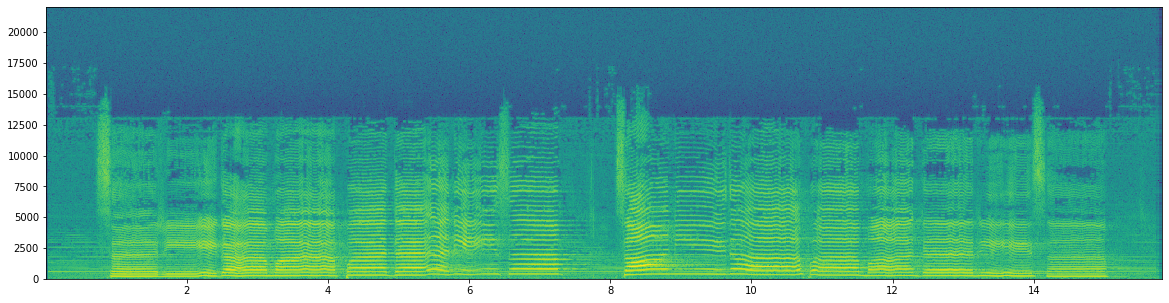

In [8]:
shankarabarana = Audio('/content/drive/My Drive/Projects/AA/Music dataset/Raga_Surabhi_3.wav')

In [9]:
shankarabarana.tonic()

193

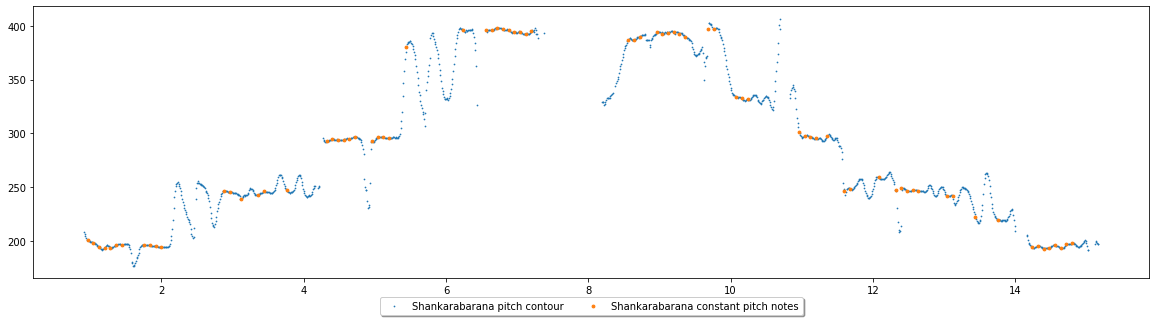

In [0]:
fig, ax = plt.subplots()
ax.scatter(shankarabarana.time_axis,shankarabarana.pitch,s=0.5,label = 'Shankarabarana pitch contour')
ax.scatter(shankarabarana.constant_pitch_time,shankarabarana.cpn,s=8,c = '#ff7f0e',label = 'Shankarabarana constant pitch notes')
#ax.hlines(shankarabarana.constant_pitch_notes,[0],[shankarabarana.time[-1]])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=2)
plt.show()

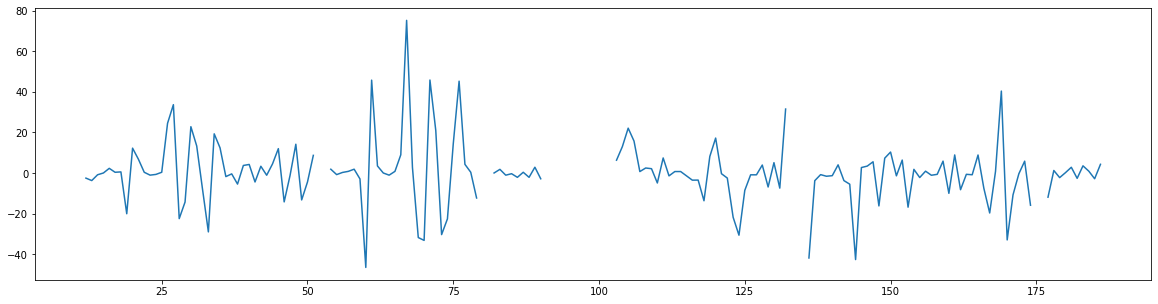

In [0]:
plt.plot(shankarabarana.diff_n)